# **Load libraries**

In [ ]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')
import sys
lesions = '/content/drive/MyDrive/AI_Lesions_Project/CHUOralLesions.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.neural_network import MLPClassifier
from pandas import read_csv
import pandas as pd
import numpy as np
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from datetime import datetime
from sklearn.svm import SVC



In [ ]:
# Define functions to do PCA,drawCorrelationMap and visualize columns
def plotCorrelationHeatmap(dataframe, columnsToPlot):
    correlation = dataframe[columnsToPlot].corr()
    plt.figure(figsize = (16,5))
    heatmap = sns.heatmap(correlation, xticklabels=correlation.columns,
                          yticklabels=correlation.columns, annot=True,cmap='Blues')


    return heatmap


def visualiseColumn(dataFrame,columnsToVisualize):
    plt.rcParams['font.family'] = 'serif'
    for column in columnsToVisualize:
      unique_values = dataFrame[column].dropna().unique()
      value_counts = dataFrame[column].value_counts()
      n_unique = len(unique_values)

      plt.bar(unique_values, value_counts, color='#1a80bb', edgecolor='black', linewidth=0.5, zorder=2)
      plt.xlabel(column)
      plt.ylabel("Number of occurrences")
      plt.title(f'Occurances by {column}',loc='left')

      # Calculate value counts and put the text at the top of the bar
      value_counts = dataFrame[column].value_counts()
      plt.grid(axis='y', color='gray', alpha=0.3, zorder=-1)

      plt.show()

In [ ]:
def plot_precision_recall(clf, X_test, y_test):
    # Predict probabilities on the test set
    y_probs = clf.decision_function(X_test)

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Compute average precision
    average_precision = average_precision_score(y_test, y_probs)

    # Plot precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    # Print classification report
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Show plot
    plt.show()

# **Data Cleaning**

In [ ]:
df = read_csv(lesions,sep=";")

In [ ]:
#replace empty string with nan
df = df.replace(r'^\s*$', np.nan, regex=True)
#replace unwanted values with nan
df['Stupefies'] = df['Stupefies'].replace('OH', np.nan)
df['Dysplasia'] = df['Dysplasia'].replace('LANGUE',np.nan)

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
Elementary lesion      0
Color                  0
Homogene               0
Well_Delimited         0
Reticulated            0
Bourgeonnant           0
Papillomatous          0
Age                  246
Sex                  213
Tobacco               41
Stupefies             40
Alcohol               15
Diagnosis             22
Dysplasia              6
dtype: int64


# **Data Analysis / Visualization**

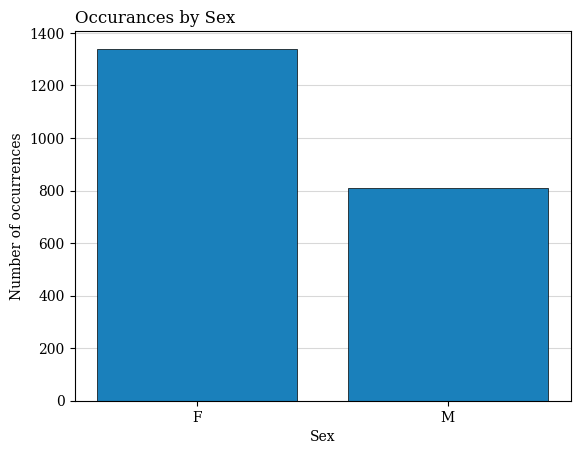

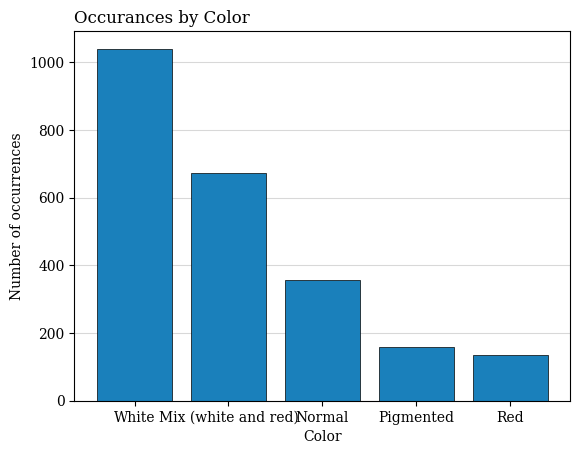

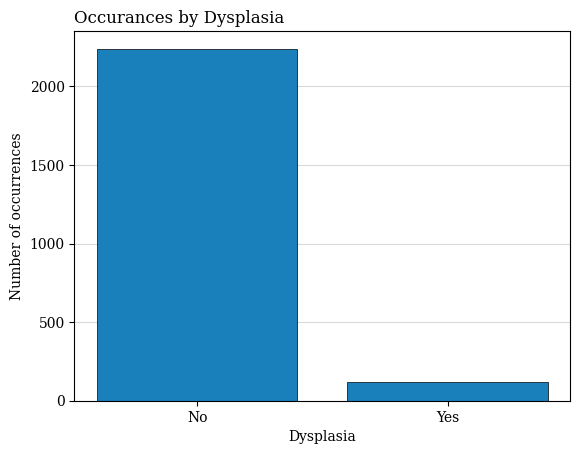

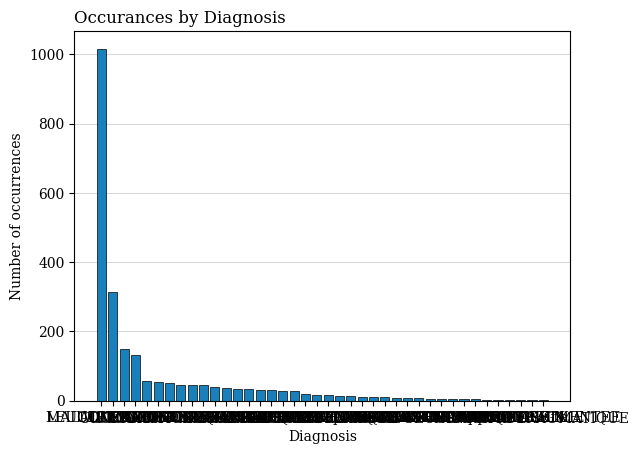

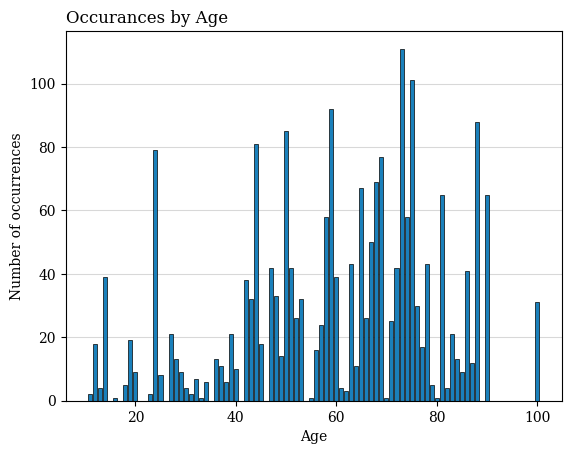

In [ ]:
visualiseColumn(df,['Sex','Color','Dysplasia','Diagnosis','Age'])


In [ ]:
df.isnull().sum()

Elementary lesion      0
Color                  0
Homogene               0
Well_Delimited         0
Reticulated            0
Bourgeonnant           0
Papillomatous          0
Age                  246
Sex                  213
Tobacco               41
Stupefies             40
Alcohol               15
Diagnosis             22
Dysplasia              6
dtype: int64

# **Label Encoding**

In [ ]:
#Label encoding categorical datasets
df.dropna(subset=['Diagnosis'], inplace=True)

for column in df.columns:
     if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

<Axes: >

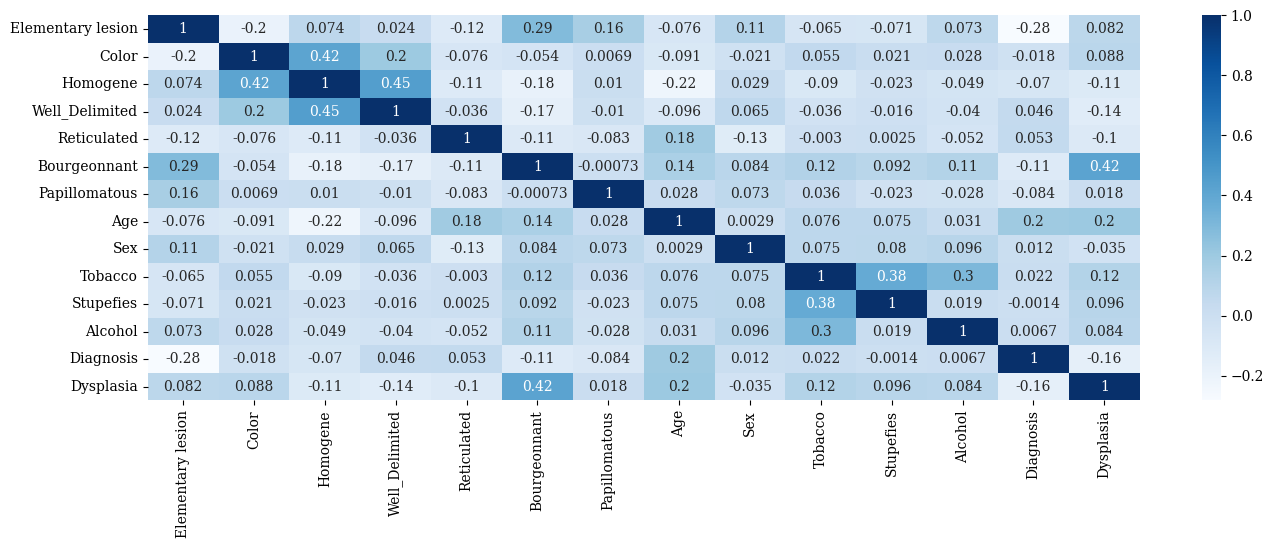

In [ ]:
plotCorrelationHeatmap(df,df.columns)


In [ ]:
# sns.pairplot(df,hue='Dysplasia')

Split Dataset


In [ ]:
# for diagnosis we need a sample size g.t.e to 30
df_filtered = df.groupby("Diagnosis").filter(lambda x: len(x) >= 30)
X = df_filtered.drop(columns=['Dysplasia', 'Diagnosis'])
y = df_filtered[['Diagnosis', 'Dysplasia']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
y['Diagnosis'].value_counts()

21    1016
23     314
20     149
0      133
26      58
4       53
1       51
35      45
39      45
33      44
15      40
37      37
38      34
30      33
7       31
12      31
Name: Diagnosis, dtype: int64

In [ ]:
# Fill NaN values
imputer = SimpleImputer(strategy='median')  # Use median to fill NaN values
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)






# **Principal Component Analysis**

Total number of components used after PCA : 12


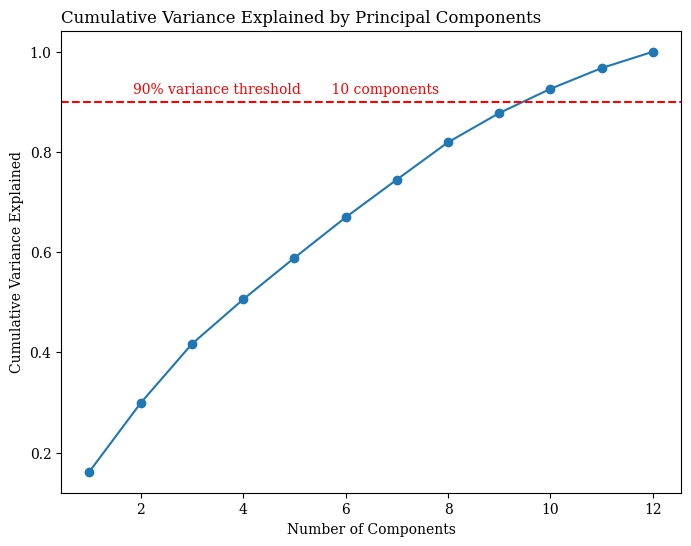

In [ ]:

pca = PCA()
pca.fit(X_train_scaled)
print(f'Total number of components used after PCA : {pca.n_components_}')

# Extract the explained variances
explained_variances = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variances = np.cumsum(explained_variances)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o', linestyle='-')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components',loc="left")
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.text(8, 0.9+0.01, '90% variance threshold       10 components  ', ha='right', va='bottom', color='r')
plt.show()




# Use 0.90 treshold
pca = PCA(0.9)
pca.fit(X_train_scaled)

pca_table = pd.DataFrame({'PCA': pca.explained_variance_ratio_}, index=[f"PC{i+1}" for i in range(0, len(pca.components_))])
# display(pca_table)


X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
eigenvalues = pd.DataFrame({'Eigenvalue': pca.explained_variance_}, index=[f"C{i+1}" for i in range(0, len(pca.components_))])
eigenvalues
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, index=[X_train.columns], columns=[f'PC{i + 1}' for i in range(len(pca.components_))])
loadings_df[['PC1', 'PC2', 'PC3', 'PC4']], eigenvalues

(                        PC1       PC2       PC3       PC4
 Elementary lesion  0.097787  0.223671 -0.575957 -0.076179
 Color             -0.393045  0.253117  0.253080 -0.099195
 Homogene          -0.558829  0.240327 -0.046529 -0.182047
 Well_Delimited    -0.475663  0.162102  0.010641 -0.221964
 Reticulated        0.081159 -0.276463  0.383556 -0.314309
 Bourgeonnant       0.325590  0.274823 -0.261867 -0.202432
 Papillomatous      0.056168  0.058071 -0.218828 -0.353803
 Age                0.278656 -0.094987  0.187425 -0.605309
 Sex                0.040614  0.330558 -0.197185 -0.268067
 Tobacco            0.213209  0.486454  0.378708  0.134651
 Stupefies          0.186309  0.382467  0.335019 -0.182034
 Alcohol            0.148964  0.381219  0.093289  0.384026,
      Eigenvalue
 C1     1.942101
 C2     1.644167
 C3     1.415348
 C4     1.067737
 C5     0.995929
 C6     0.970138
 C7     0.906332
 C8     0.895328
 C9     0.700732
 C10    0.579987)

In [ ]:
# Two dataset to train the model
all_dataset = [(X_train_pca,X_test_pca),(X_train_scaled,X_test_scaled)]

In [ ]:
# # Train SVM model
y_train_diagnosis = y_train.drop(columns = ['Dysplasia'])
y_test_diagnosis = y_test.drop(columns=['Dysplasia'])

# for x_train,x_test in all_dataset:
#   use_SVM(x_train,x_test,y_train_diagnosis,y_test_dysplasia)

Algorithm SVM
Best score: 0.7149639559442146
Best Params {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
ROC AUC: 0.95

Algorithm DecisionTree
Best score: 0.8781850552442793
Best Params {'max_depth': None, 'min_samples_split': 2}
ROC AUC: 0.92

Algorithm RandomForest
Best score: 0.8675411495697404
Best Params {'max_depth': None}
ROC AUC: 0.97



Algorithm KNN
Best score: 0.8509783386570315
Best Params {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
ROC AUC: 0.96



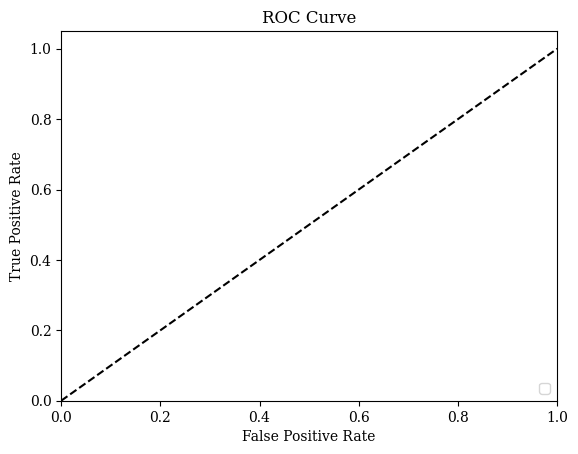

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc



# Define models and parameters
models = {
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

params = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    'DecisionTree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'RandomForest': {'max_depth': [None, 10, 20]},
    'KNN': {'n_neighbors': range(1,10), 'p': [1, 2], 'weights': ['uniform', 'distance']}
}


# Grid search for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train_diagnosis.to_numpy().ravel())
    best_model = grid_search.best_estimator_

    y_score = best_model.predict_proba(X_test_scaled)

    # Assuming y_test_diagnosis is a multiclass target, you need to convert it to one-hot encoding
    y_test_one_hot = pd.get_dummies(y_test_diagnosis)

    roc_auc = roc_auc_score(y_test_one_hot, y_score, multi_class='ovr')  # One-vs-Rest strategy

    print("Algorithm", name)
    print("Best score:", grid_search.best_score_)
    print("Best Params", grid_search.best_params_)
    print(f"ROC AUC: {roc_auc:.2f}")
    print("")


plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Evaluate models
evaluation_metrics = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    evaluation_metrics[name] = {
        'Accuracy': accuracy_score(y_test_diagnosis, y_pred),
        'Precision': precision_score(y_test_diagnosis, y_pred, average='macro'),
        'Recall': recall_score(y_test_diagnosis, y_pred, average='macro'),
        'F1-Score': f1_score(y_test_diagnosis, y_pred, average='macro')
    }
    # Confusion matrix
    cm = confusion_matrix(y_test_diagnosis, y_pred)
    sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f'{name} Results')
    plt.show()

[]


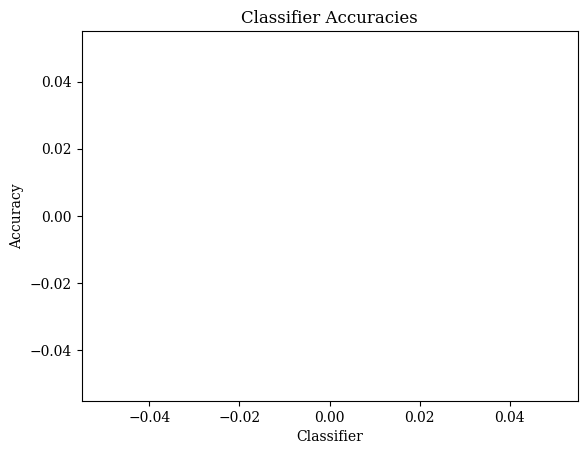

In [ ]:
# Extract accuracy values

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [evaluation_metrics[classifier]['Accuracy']*100 for classifier in evaluation_metrics]
print(accuracies)
# Plot histogram
classifiers =list(evaluation_metrics.keys())
plt.bar(classifiers, accuracies)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')
plt.show()

<Axes: ylabel='Diagnosis'>

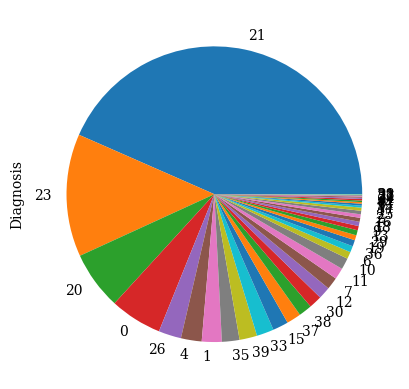

In [ ]:
df['Diagnosis'].value_counts().plot.pie()

# **ML**

**SVM**

In [ ]:
# %pip install shap
import shap
svm = SVC(kernel='rbf', probability=True, C=10, gamma='auto')
svm.fit(X_train, y_train_diagnosis)

shap.initjs()
explainer = shap.KernelExplainer(svm.predict_proba, shap.sample(X_train, 500), link="logit")
shap_values = explainer.shap_values(shap.sample(X_test, 100), nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

In [ ]:
dataset = pd.read_csv(lesions, sep=";")
dataset.dropna(subset=['Diagnosis'], inplace=True)
X_display = dataset['Diagnosis'].unique()
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_names=X_display)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

**kNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')
knn.fit(X_train, y_train_diagnosis)

In [ ]:
knn_explainer = shap.KernelExplainer(knn.predict_proba, shap.sample(X_train, 500))
knn_shap_values = knn_explainer.shap_values(shap.sample(X_test, 100), nsamples=100)

In [ ]:
shap.summary_plot(knn_shap_values, X_test, class_names=X_display, plot_size=(9, 6))

In [ ]:
shap.initjs()
shap.force_plot(knn_explainer.expected_value[0], knn_shap_values[0], X_test)

**Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(max_depth = None)
rfc.fit(X_train, y_train_diagnosis)

In [ ]:
rfc_explainer = shap.KernelExplainer(rfc.predict_proba, shap.sample(X_train, 500))
rfc_shap_values = rfc_explainer.shap_values(shap.sample(X_test, 100), nsamples=100)

In [ ]:
shap.initjs()
shap.summary_plot(rfc_shap_values, X_test, class_names=X_display, plot_size=(12, 8))

In [ ]:
shap.initjs()
shap.force_plot(rfc_explainer.expected_value[0], rfc_shap_values[0], X_test)

In [ ]:
for i in df.columns:
  print(i)
  print(df[i].unique(), dataset[i].unique())

Elementary lesion
[2 0 4 3 1] ['No loss of substance' 'Bubble' 'With volume augmentation'
 'With loss of substance' 'No lesion']
Color
[4 0 1 2 3] ['White' 'Mix (white and red)' 'Normal' 'Pigmented' 'Red']
Homogene
[0 1] ['No' 'Yes']
Well_Delimited
[1 0] ['Yes' 'No']
Reticulated
[0 1] ['No' 'Yes']
Bourgeonnant
[0 1] ['No' 'Yes']
Papillomatous
[0 1] ['No' 'Yes']
Age
[ 73.  75.  59.  88.  50.  44.  24.  69.  68.  65.  81.  90.  74.  58.
  67.  63.  78.  51.  72.  47.  86.  14.  60.  42.  48.  43.  53. 100.
  76.  52.  66.  71.  57.  27.  83.  39.  19.  45.  12.  77.  56.  49.
  84.  28.  36.  87.  64.  37.  40.  29.  20.  nan  85.  25.  32.  38.
  34.  18.  79.  13.  30.  82.  61.  62.  23.  31.  11.  55.  70.  16.
  33.  80.] [ 73.  75.  59.  88.  50.  44.  24.  69.  68.  65.  81.  90.  74.  58.
  67.  63.  78.  51.  72.  47.  86.  14.  60.  42.  48.  43.  53. 100.
  76.  52.  66.  71.  57.  27.  83.  39.  19.  45.  12.  77.  56.  49.
  84.  28.  36.  87.  64.  37.  40.  29.  20.  nan  